# Analyzing Livestream Data from Twitch 

In order to connect to Twitch chat, one should use Python Sockets to connect via IRC. To stream messages from the Twitch IRC, you need to get a token for authentication. To do that, you need a Twitch account. I've created a development team account. Now, you need to go to the following [link]( https://twitchapps.com/tmi/) while signed in to obtain an Auth token for your Twitch account. You click authorize and keep that token handy for later. 

Below, we define a few constants for obtaining Twitch data. Channel responds to the streamer's name and can be the name of any channel one is interested in. Currently, this is set up for one chat stream at a time. 

In [1]:
# Important Constants for Connection to Twitch Channel Feed
server = 'irc.chat.twitch.tv'
port = 6667
nickname = 'acn_development_team' # '<YOUR_USERNAME>'
# token = '<YOUR_AUTH_TOKEN>'
channel = '#sweet_anita' # The hashtag before the username here is SUPER important. 

# Connecting to Twitch using Sockets

To establish a connection to Twitch IRC, we'll use Python's socket library. So we first instantiate a socket:

In [2]:
import socket
sock = socket.socket()
sock.settimeout(120)

Next, we need to connect the socket to Twitch by calling connect() with the server and port previously defined. 

In [3]:
sock.connect((server,port))

Once connected, we need to send our token and nickname for authentication as well as the channel we care about. These are sent via encoded strings, so we need to send them in this very specific format: 

In [4]:
# where 'utf-8' encoding encodes the string into bytes which allows it to be sent over the socket. 
sock.send(f"PASS {token}\n".encode('utf-8')) # carries token 
sock.send(f"NICK {nickname}\n".encode('utf-8')) # carries nickname
sock.send(f"JOIN {channel}\n".encode('utf-8')) # carries channel 

18

In [ ]:
# Recieving Channel Messages 
# Example: Getting a single response. 
# This is commented out because it's just for testing out one example. 

# resp = sock.recv(2048).decode('utf-8') #2048 is the buffer size in bytes, amount of data to recieve. 
# resp


# sock.close() # Use this to open/close the socket. 

In [5]:
# Currently, the socket gets responses but we need to check for new messages and log messages as they come in. 
# The proper way to do this is to set up a logger that writes messages to a file and a loop that will check for new messages as the socket's open. 

import logging

logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s — %(message)s',
                    datefmt='%Y-%m-%d_%H:%M:%S',
                    handlers=[logging.FileHandler('chat3.log', encoding='utf-8')]) # I called it "chat3.log", you can call it anything .log

# Debug means all levels of logging can be written to the file. 
# Format is how we want the line to look, which will be time/message. Date format is how the time of the format is recorded. 
# FileHandler to handlers is passed which creates a file in the directory and logs info to chat.log. 

In [ ]:
# logging.info(resp) # We can open our repository and notice chat.log is updated now! 
# tail -f chat3.log -> in terminal to post stuff in chat. 

In [ ]:
# Continuously checking for new messages in a loop. When connected to IRC, we want to make sure to send "PONG" if server sends "PING."
# Also want to parse emojis so they can be written to a file. There's an emoji library that maps emoji to word meaning. 

from emoji import demojize

while True:
    resp = sock.recv(2048).decode('utf-8')

    if resp.startswith('PING'):
        sock.send("PONG\n".encode('utf-8'))
    
    elif len(resp) > 0:
        logging.info(demojize(resp))
        
# This will keep running until you stop it. 
# To see the messages in real-time open a new terminal, navigate to the log's location, and run tail -f chat.log.

In [ ]:
sock.close() # Use this to open/close the socket. 

# Parsing the Chat Logs from Twitch
In this case, we want to parse the chat log into a Pandas DataFrame to prepare for analysis. This means that we want to have the username, message, date, and time information (but really I care only about the message). Because we need to get data from each line, we need to be strategic about how we read info.

In [21]:
import pandas as pd
from datetime import datetime
import re

def get_chat_dataframe(file):
    data = []

    with open(file, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
        
        for line in lines:
            try:
                time_logged = line.split('—')[0].strip()
                time_logged = datetime.strptime(time_logged, '%Y-%m-%d_%H:%M:%S')

                username_message = line.split('—')[1:]
                username_message = '—'.join(username_message).strip()

                username, channel, message = re.search(
                    ':(.*)\!.*@.*\.tmi\.twitch\.tv PRIVMSG #(.*) :(.*)', username_message
                ).groups()

                d = {
                    'dt': time_logged,
                    'channel': channel,
                    'username': username,
                    'message': message
                }

                data.append(d)
            
            except Exception:
                pass
            
    return pd.DataFrame().from_records(data)

In [22]:
df = get_chat_dataframe('chat3.log') # I called it chat3.log, you can call it whatever you called it previously. 

print(df.shape)

df

df.drop(1248, inplace=True)# doing this because I want to remove a blank message. 

# If you have blank messages in the dataframe, it will create complications later down the line. Please fix this now! 
# I admit there are more systematic ways to remove blank messages than a manual df.drop. 

(6247, 4)


In [23]:
df

,dt,channel,username,message
0,2020-11-02 12:46:03,sweet_anita,baphomet1998,so dick was off the menu
1,2020-11-02 12:46:04,sweet_anita,killer23088032,"@Sweet_Anita if Terence wants to hurt you, wha..."
2,2020-11-02 12:46:04,sweet_anita,saow227,SUPERIOR CONDIMENT?
3,2020-11-02 12:46:05,sweet_anita,ceruleanparrot,wow i went vegan at thirteen!
4,2020-11-02 12:46:05,sweet_anita,mlgamer227,I wanna be vegitarian
...,...,...,...,...
6242,2020-11-02 13:59:00,sweet_anita,someonedude23,!fishes
6243,2020-11-02 13:59:00,sweet_anita,7obiczek,@BaguetteFromageVinRouge gn
6244,2020-11-02 13:59:00,sweet_anita,streamelements,"@Someonedude23, Someonedude23 has 210 fishes"
6245,2020-11-02 13:59:03,sweet_anita,rathlive,U goare sexy


In [24]:
# Now, employing my own custom data processing. I'm personally only interested in the messages feature! 
df['message'].head()

0                             so dick was off the menu
1    @Sweet_Anita if Terence wants to hurt you, wha...
2                                  SUPERIOR CONDIMENT?
3                        wow i went vegan at thirteen!
4                                I wanna be vegitarian
Name: message, dtype: object

# Cleaning Dataset, Visualizing Datset, and Building LDA Model 

In [25]:
# Import modules

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

#TextHero
# !pip install texthero -U   
import texthero as hero

In [26]:
#Pass a custom pipeline as argument to clean

from texthero import preprocessing
# https://pypi.org/project/texthero/
# Texthero is a really good library built off of Pandas and it allows for those with minimal knowledge of the NLP space to utilize powerful tools. 

custom_pipeline = [preprocessing.lowercase, # much easier than previous solution which was to df.remove. 
                   preprocessing.remove_punctuation,
                   preprocessing.remove_urls]
data = hero.clean(df['message'])

In [27]:
# Custom STOPWORDS removal
from texthero import stopwords
default_stopwords = stopwords.DEFAULT
custom_stopwords = default_stopwords.union(set(["twitch","make", "use", "thank", "content", "good", "use",
                                                "think", "need", "harrisheller", "like", "stream",
                                               "kekw","catjam","tim","timthetatman","tatkevinh",
                                               "wipz","docspin","pog","tatlove","lol","lul","omegalul",
                                               "biblethump","clap","tathypers","pepeja","kappa","tattopd","ppsmoke",
                                               "pepelaugh","gopackgo","gachihyper","tatkevinh", "wipz",
                                               "pausechamp","yep","lmao","jack","lulw","monkaw","kreygasm",
                                               "pepega","peped","foxsalt","pogchamp","xqcn","get","back",
                                               "tattuff","tatfat","tatpumpkin","lmao","sadge","sippy",
                                               "pogu","poggers","consolecd","widepeepohappy","pogu","tategg2",
                                               "modcheck","timmy","tathmm","tats","got","com","babyrage",
                                               "xqcp","tatw","pokiw","know", "thats","pepocd","tatafk",
                                               "4weird","tatkkevin", "tatblanket","tatglam","tategg1","wutface",
                                               "blobdance", "kapp","tatbruh","kappapride","facebaby","xqc",
                                               "xqcm","bora","hyperclap","tatlit","5head","gachibass", "go", "ur",
                                                "yes","going","would","im","oh","dez","taty","tk","u","sg", "dont",
                                                "hey","hf","look","anita","anitaheart","leeper","anitahey",
                                                "anitadab","anitadoubt","anitahands", "anitalul","anitapog","anitasword",
                                                "anitaprime","anitafeels","residentsleeper","anitapride","anital",
                                                "anitabiscuit", "thing","widepeeposad","anitahype","among", "lesbianpride",
                                                "heyguys","seemsgood","notlikethis","hi","also","much","yeah",
                                               ])) ## Add as per requirement
# data = hero.remove_stopwords(data, default_stopwords)
data = hero.remove_stopwords(data, custom_stopwords)

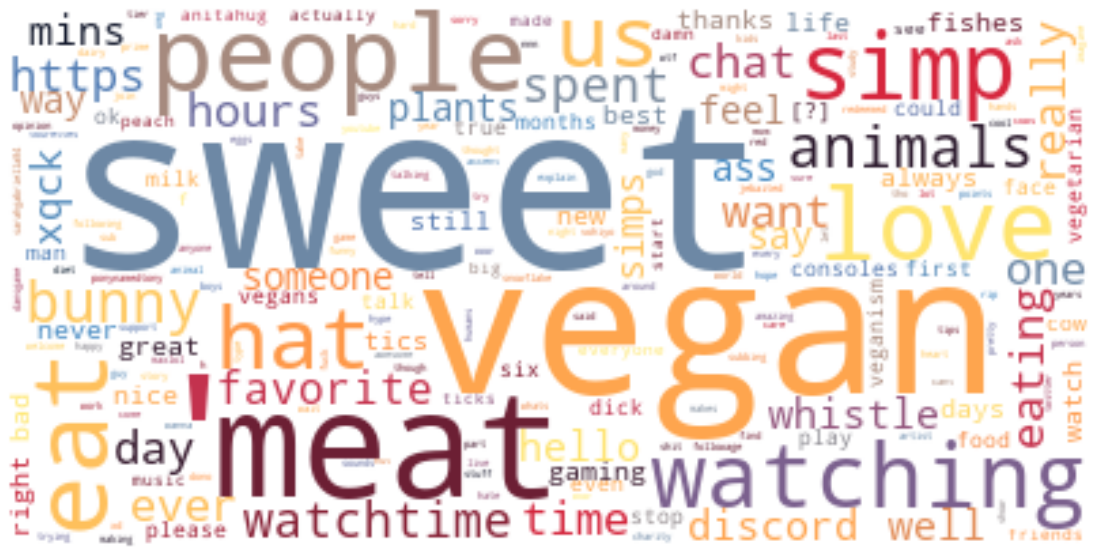

In [28]:
hero.visualization.wordcloud(data, font_path = None, width = 400, height = 200, max_words=200, 
                             mask=None, contour_width=0, 
                             contour_color='PAPAYAWHIP', background_color='WHITE', 
                             relative_scaling='auto', colormap=None, return_figure=False)

In [30]:
# Tokenize

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['dick', 'menu'], ['sweet', 'terence', 'wants', 'hurt', 'part', 'body']]


In [31]:
# Lemmatize
# Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, 
# normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.
# tl;dr put the verbs in their "stem" form. 

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adjective, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:50])

['', 'sweet terence want hurt part body', 'superior condiment', 'go', '', '', 'superior condiment', 'sub prime gaming', 'sweet want year', 'make mistake', 'ponynamedtony', 'ponynamedtony', 'sweet secret whistling can', 'tic cooking', 'superior condiment', 'quit vegetarian', 'ponynamedtony', 'internet quite eye opener', 'sweet candy spicy food', 'ponynamedtony', 'consider play minecraft', 'favorite', 'place live', 'superior condiment', '', 'sour', '', 'superior condiment', 'make tho', 'land website first visit', 'ponynamedtony evening', 'ponynamedtony evening', '', 'stop ask favorite', 'armorant sugar may spell wrong less refined white sugar', '', '', 'milk', 'favorite music artist', 'superior condiment', 'armorant', 'ponynamedtony', 'ponynamedtony', '', 'ask', 'imglitch permanently ban', 'sgtmonkey stop spamme symbol warn', 'favorite', '', '']


In [32]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
# !pip install -U pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
# Word-Document Matrix
# This converts a collection of text documents to a matrix of token counts. 
# A document-term matrix or term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. 
# In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms. 

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum number occurences of a word required
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')  # num of characters > 3
                            

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [34]:
# Build LDA model with Sklearn

lda_model = LatentDirichletAllocation(n_components=15,               # Number of topics
                                      max_iter=10,                   # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,              # Random state
                                      batch_size=128)                # n docs in each learning iter
                                            
                                      
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=15,
                          random_state=100)


In [35]:
#Evaluate model quality

# Log Likelihood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp((-1) * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))


Log Likelihood:  -25012.217822028397
Perplexity:  177.60915622632535


In [36]:
# Grid Search for Best LDA Model
# Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. 
# It is an exhaustive search that is performed on a the specific parameter values of a model. The model is also known as an estimator.
# This is computationally expensive and usually takes time... 

from sklearn.model_selection import GridSearchCV

# Define Search Param
params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Model
lda = LatentDirichletAllocation()

# Grid Search
model = GridSearchCV(lda, param_grid=params)

# Perform Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [37]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -6099.564886583488
Model Perplexity:  156.4131423407594


In [38]:
#Visualize with pyLDAvis

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  12.344294
5       0.648955  71.707100       2        1  12.328895
8      71.019684   9.971006       3        1  10.951328
2       3.785981  33.185135       4        1  10.507746
3     -42.666500  -9.222070       5        1  10.131439
4      -3.621689 -43.526516       6        1   9.488356
9      -3.632402  -4.171708       7        1   9.153810
1     -36.584400  35.804413       8        1   8.787364
7      44.391380  50.615383       9        1   8.507548
0      40.235809 -31.591665      10        1   7.799219, topic_info=       Term        Freq       Total Category  logprob  loglift
143   sweet  231.000000  231.000000  Default  30.0000  30.0000
35      eat  162.000000  162.000000  Default  29.0000  29.0000
108  people  115.000000  115.000000  Default  28.0000  28.0000
171   watch  109.000000  109.000000  Default  27.0000  27.0000
90     love   91.000000   91.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
171   watch    0.241122  109.253343  Topic10  -7.3537  -3.5650
86     long    0.108236   11.194711  Topic10  -8.1547  -2.0877
174  weight    0.107413   11.238486  Topic10  -8.1623  -2.0993
134    stop    0.107397   29.125781  Topic10  -8.1625  -3.0517
76      job    0.107396   13.944021  Topic10  -8.1625  -2.3151

[384 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         6  0.932299    accent
1        10  0.969140  actually
2         6  0.953286   amazing
3         3  0.095204    animal
3         6  0.892536    animal
...     ...       ...       ...
176       1  0.258135      work
176      10  0.742138      work
177       5  0.960289     world
178       8  0.970403     wrong
179       8  0.967531      year

[249 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 9, 3, 4, 5, 10, 2, 8, 1])

In [42]:
# Reflections:
# This exercise shows how you can analyze a massive corpus of text and split data into "topics" which contain certain words that appear 
# frequently amongst those topics. In this case, we have 10 topics and 10 words that reflect those topics. What this data can tell us is 
# how important and how frequent certain words are in the corpus - what themes/etc. may emerge. 

# Show top n keywords for each topic

def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,favorite,really,true,actually,music,work,person,artist,learn,hold
Topic 1,day,sweet,year,month,follow,thank,opinion,kid,hour,story
Topic 2,simp,say,want,time,hand,new,let,point,support,tourette
Topic 3,talk,come,friend,great,tick,feel,tic,man,think,explain
Topic 4,animal,make,cow,live,life,milk,amazing,rabbit,happy,accent
Topic 5,sweet,watch,spend,hour,min,play,stop,wait,night,dog
Topic 6,love,meat,eat,bad,plant,way,whistle,kill,hear,fish
Topic 7,nice,right,try,face,good,tell,big,console,sub,cool
Topic 8,eat,watchtime,start,study,sound,guy,food,care,redeem,mean
Topic 9,people,game,human,ask,hate,diet,awesome,vegetarian,hard,type


In [43]:
# Now, focusing on Semantic Text Similarity.
# First, we're adding our import statements. 
import pandas as pd
import numpy as np
import spacy
import os 
import re
import operator
import pickle
import nltk 
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
# Now, doing Word Tokenization
# Tokenization is hwen each entry in the data is broken down into a set of words.
import nltk
# nltk.download('punkt')

df['Word tokenize']= [word_tokenize(entry) for entry in df.message]

In [45]:
df['Word tokenize']

0                         [so, dick, was, off, the, menu]
1       [@, Sweet_Anita, if, Terence, wants, to, hurt,...
2                                [SUPERIOR, CONDIMENT, ?]
3                  [wow, i, went, vegan, at, thirteen, !]
4                            [I, wan, na, be, vegitarian]
                              ...                        
6242                                          [!, fishes]
6243                     [@, BaguetteFromageVinRouge, gn]
6244    [@, Someonedude23, ,, Someonedude23, has, 210,...
6245                                     [U, goare, sexy]
6246    [@, baguettefromagevinrouge, GOOD, DREAMS, ani...
Name: Word tokenize, Length: 6246, dtype: object

In [46]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
def wordLemmatizer(data):
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    file_clean_k =pd.DataFrame()
    
    for index,entry in enumerate(data):
        
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets - I turned this part off for now. 
#             if len(word)>1 and word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
            # The final processed set of words for each iteration will be stored in 'text_final'
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words)
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words)
                #file_clean_k=file_clean_k.replace(to_replace ="\[.", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace ="'", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace =" ", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace ='\]', value = '', regex = True)
    return file_clean_k

In [224]:
# # My version of lemmatization based on the Coursera code/work I've done previously... 

# # Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, 
# # normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.
# # tl;dr put the verbs in their "stem" form. 

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
#     return texts_out

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


In [241]:
# Do lemmatization keeping only Noun, Adjective, Verb, Adverb
# This is using my version. 
# df_clean = lemmatization(df['Word tokenize'], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print(df_clean)

In [47]:
df.shape

(6246, 5)

In [48]:
df


,dt,channel,username,message,Word tokenize
0,2020-11-02 12:46:03,sweet_anita,baphomet1998,so dick was off the menu,"[so, dick, was, off, the, menu]"
1,2020-11-02 12:46:04,sweet_anita,killer23088032,"@Sweet_Anita if Terence wants to hurt you, wha...","[@, Sweet_Anita, if, Terence, wants, to, hurt,..."
2,2020-11-02 12:46:04,sweet_anita,saow227,SUPERIOR CONDIMENT?,"[SUPERIOR, CONDIMENT, ?]"
3,2020-11-02 12:46:05,sweet_anita,ceruleanparrot,wow i went vegan at thirteen!,"[wow, i, went, vegan, at, thirteen, !]"
4,2020-11-02 12:46:05,sweet_anita,mlgamer227,I wanna be vegitarian,"[I, wan, na, be, vegitarian]"
...,...,...,...,...,...
6242,2020-11-02 13:59:00,sweet_anita,someonedude23,!fishes,"[!, fishes]"
6243,2020-11-02 13:59:00,sweet_anita,7obiczek,@BaguetteFromageVinRouge gn,"[@, BaguetteFromageVinRouge, gn]"
6244,2020-11-02 13:59:00,sweet_anita,streamelements,"@Someonedude23, Someonedude23 has 210 fishes","[@, Someonedude23, ,, Someonedude23, has, 210,..."
6245,2020-11-02 13:59:03,sweet_anita,rathlive,U goare sexy,"[U, goare, sexy]"


In [49]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# df_clean = wordLemmatizer(df['Word tokenize'][0:10]) 
# FOR THE WHOLE DATASET: 
df_clean = wordLemmatizer(df['Word tokenize'])
df_clean.shape

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ronak.k.bhatia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ronak.k.bhatia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


(6246, 1)

In [50]:
df_clean=df_clean.replace(to_replace ="\[.", value = '', regex = True)
df_clean=df_clean.replace(to_replace ="'", value = '', regex = True)
df_clean=df_clean.replace(to_replace =" ", value = '', regex = True)
df_clean=df_clean.replace(to_replace ='\]', value = '', regex = True)
df_clean

<>:1: DeprecationWarning: invalid escape sequence \[
<>:4: DeprecationWarning: invalid escape sequence \]
<>:1: DeprecationWarning: invalid escape sequence \[
<>:4: DeprecationWarning: invalid escape sequence \]
<ipython-input-50-22e53e1bfe00>:1: DeprecationWarning: invalid escape sequence \[
  df_clean=df_clean.replace(to_replace ="\[.", value = '', regex = True)
<ipython-input-50-22e53e1bfe00>:4: DeprecationWarning: invalid escape sequence \]
  df_clean=df_clean.replace(to_replace ='\]', value = '', regex = True)


,Keyword_final
0,"so,dick,be,off,the,menu"
1,"@,Sweet_Anita,if,Terence,want,to,hurt,you,,,wh..."
2,"SUPERIOR,CONDIMENT,?"
3,"wow,i,go,vegan,at,thirteen,!"
4,"I,wan,na,be,vegitarian"
...,...
6241,"!,fish"
6242,"@,BaguetteFromageVinRouge,gn"
6243,"@,Someonedude23,,,Someonedude23,have,210,fish"
6244,"U,goare,sexy"


In [51]:
df.insert(loc=4, column='Clean_Keyword', value=df_clean['Keyword_final'].tolist())

# df['Clean_Keyword'] = wordLemmatizer(df['Word tokenize'])

In [52]:
df['Clean_Keyword']=df['Clean_Keyword'].replace(to_replace ="\[.", value = '', regex = True)
df['Clean_Keyword']=df['Clean_Keyword'].replace(to_replace ="'", value = '', regex = True)
df['Clean_Keyword']=df['Clean_Keyword'].replace(to_replace =" ", value = '', regex = True)
df['Clean_Keyword']=df['Clean_Keyword'].replace(to_replace ='\]', value = '', regex = True)
df['Clean_Keyword']

<>:1: DeprecationWarning: invalid escape sequence \[
<>:4: DeprecationWarning: invalid escape sequence \]
<>:1: DeprecationWarning: invalid escape sequence \[
<>:4: DeprecationWarning: invalid escape sequence \]
<ipython-input-52-3de05bd37bf6>:1: DeprecationWarning: invalid escape sequence \[
  df['Clean_Keyword']=df['Clean_Keyword'].replace(to_replace ="\[.", value = '', regex = True)
<ipython-input-52-3de05bd37bf6>:4: DeprecationWarning: invalid escape sequence \]
  df['Clean_Keyword']=df['Clean_Keyword'].replace(to_replace ='\]', value = '', regex = True)


0                                 so,dick,be,off,the,menu
1       @,Sweet_Anita,if,Terence,want,to,hurt,you,,,wh...
2                                    SUPERIOR,CONDIMENT,?
3                            wow,i,go,vegan,at,thirteen,!
4                                  I,wan,na,be,vegitarian
                              ...                        
6242                                               !,fish
6243                         @,BaguetteFromageVinRouge,gn
6244        @,Someonedude23,,,Someonedude23,have,210,fish
6245                                         U,goare,sexy
6246     @,baguettefromagevinrouge,GOOD,DREAMS,anitaHeart
Name: Clean_Keyword, Length: 6246, dtype: object

In [59]:
df

,dt,channel,username,message,Clean_Keyword,Word tokenize
0,2020-11-02 12:46:03,sweet_anita,baphomet1998,so dick was off the menu,"so,dick,be,off,the,menu","[so, dick, was, off, the, menu]"
1,2020-11-02 12:46:04,sweet_anita,killer23088032,"@Sweet_Anita if Terence wants to hurt you, wha...","@,Sweet_Anita,if,Terence,want,to,hurt,you,,,wh...","[@, Sweet_Anita, if, Terence, wants, to, hurt,..."
2,2020-11-02 12:46:04,sweet_anita,saow227,SUPERIOR CONDIMENT?,"SUPERIOR,CONDIMENT,?","[SUPERIOR, CONDIMENT, ?]"
3,2020-11-02 12:46:05,sweet_anita,ceruleanparrot,wow i went vegan at thirteen!,"wow,i,go,vegan,at,thirteen,!","[wow, i, went, vegan, at, thirteen, !]"
4,2020-11-02 12:46:05,sweet_anita,mlgamer227,I wanna be vegitarian,"I,wan,na,be,vegitarian","[I, wan, na, be, vegitarian]"
...,...,...,...,...,...,...
6242,2020-11-02 13:59:00,sweet_anita,someonedude23,!fishes,"!,fish","[!, fishes]"
6243,2020-11-02 13:59:00,sweet_anita,7obiczek,@BaguetteFromageVinRouge gn,"@,BaguetteFromageVinRouge,gn","[@, BaguetteFromageVinRouge, gn]"
6244,2020-11-02 13:59:00,sweet_anita,streamelements,"@Someonedude23, Someonedude23 has 210 fishes","@,Someonedude23,,,Someonedude23,have,210,fish","[@, Someonedude23, ,, Someonedude23, has, 210,..."
6245,2020-11-02 13:59:03,sweet_anita,rathlive,U goare sexy,"U,goare,sexy","[U, goare, sexy]"


In [60]:
df_clean

,Keyword_final
0,"so,dick,be,off,the,menu"
1,"@,Sweet_Anita,if,Terence,want,to,hurt,you,,,wh..."
2,"SUPERIOR,CONDIMENT,?"
3,"wow,i,go,vegan,at,thirteen,!"
4,"I,wan,na,be,vegitarian"
...,...
6241,"!,fish"
6242,"@,BaguetteFromageVinRouge,gn"
6243,"@,Someonedude23,,,Someonedude23,have,210,fish"
6244,"U,goare,sexy"


In [61]:
df_clean.size

6246

In [62]:
df

,dt,channel,username,message,Clean_Keyword,Word tokenize
0,2020-11-02 12:46:03,sweet_anita,baphomet1998,so dick was off the menu,"so,dick,be,off,the,menu","[so, dick, was, off, the, menu]"
1,2020-11-02 12:46:04,sweet_anita,killer23088032,"@Sweet_Anita if Terence wants to hurt you, wha...","@,Sweet_Anita,if,Terence,want,to,hurt,you,,,wh...","[@, Sweet_Anita, if, Terence, wants, to, hurt,..."
2,2020-11-02 12:46:04,sweet_anita,saow227,SUPERIOR CONDIMENT?,"SUPERIOR,CONDIMENT,?","[SUPERIOR, CONDIMENT, ?]"
3,2020-11-02 12:46:05,sweet_anita,ceruleanparrot,wow i went vegan at thirteen!,"wow,i,go,vegan,at,thirteen,!","[wow, i, went, vegan, at, thirteen, !]"
4,2020-11-02 12:46:05,sweet_anita,mlgamer227,I wanna be vegitarian,"I,wan,na,be,vegitarian","[I, wan, na, be, vegitarian]"
...,...,...,...,...,...,...
6242,2020-11-02 13:59:00,sweet_anita,someonedude23,!fishes,"!,fish","[!, fishes]"
6243,2020-11-02 13:59:00,sweet_anita,7obiczek,@BaguetteFromageVinRouge gn,"@,BaguetteFromageVinRouge,gn","[@, BaguetteFromageVinRouge, gn]"
6244,2020-11-02 13:59:00,sweet_anita,streamelements,"@Someonedude23, Someonedude23 has 210 fishes","@,Someonedude23,,,Someonedude23,have,210,fish","[@, Someonedude23, ,, Someonedude23, has, 210,..."
6245,2020-11-02 13:59:03,sweet_anita,rathlive,U goare sexy,"U,goare,sexy","[U, goare, sexy]"


In [264]:
# df = df.drop(['Word tokenize','Clean_Keyword'],axis=1) # will drop the columns "Word Tokenize" and "Clean_Keyword" 

In [265]:
# df.to_csv("df_twitch.csv", index=False, header=True) # will convert the dataframe to a CSV format, if that's something you want. 

In [65]:
df.Clean_Keyword[6] #example output

'SUPERIOR,CONDIMENT,!'

In [66]:
!pip install --upgrade tensorflow-gpu
#Install TF-Hub.
!pip install tensorflow-hub
!pip install seaborn

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [69]:
# Yay more imports
import pandas as pd
import numpy as np
import re, string
import os 
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel

In [70]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
Hub version:  0.7.0
GPU is NOT AVAILABLE


Now, using TF-IDF to create a document search tool. TF-IDF is the process of calculating the weight of each word (signifying the importance of the word in the corpus/document). The algorithm is used mainly for retrieving information and text mining.

TF (Term Frequency) is how many times a word appears in a document divided by the number of the words in the document.

IDF (Inverse Data Frequency) is the log of the number of documents divided by the number of documents with the word W that we're interested in.

TF-IDF is just these two numbers multiplied together - sklearn implements this feature for you in their library.

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
import operator

## Create Vocabulary
vocabulary = set()

for doc in df.Clean_Keyword:
    vocabulary.update(doc.split(','))

vocabulary = list(vocabulary)

# Intializating the tfIdf model
tfidf = TfidfVectorizer(vocabulary=vocabulary,dtype=np.float32)

# Fit the TfIdf model
tfidf.fit(df.Clean_Keyword)

# Transform the TfIdf model
tfidf_tran=tfidf.transform(df.Clean_Keyword)

In [72]:
vocabulary[0:10] # for example

['',
 'may',
 'Overclockers',
 'TwitchUnity',
 'ftw',
 'Too',
 '7804/966340',
 'PLASIC',
 'katycat500',
 'simping']

In [73]:
vocabulary = list(filter(None, vocabulary)) # just removing the empty '' in the list! 

In [76]:
# vocabulary[0:100] # rechecking the list 

In [80]:
# Saving the trained TF-ID Model
# I uploaded this to Colab and then ran this. 
with open('/Users/ronak.k.bhatia/Desktop/Data_STA/tfid.pkl','wb') as handle:
    pickle.dump(tfidf_tran, handle)

# Load the model! 
t = pickle.load(open('/Users/ronak.k.bhatia/Desktop/Data_STA/tfid.pkl','rb'))

Now, I have to actually create a text file that contains all the words that I'm interested in.

In [81]:
# !ls

Data
Non-Optimized-Versions
Optimized-Versions
README.md
Semantic_Text_Similarity_Exploration.ipynb
Twitch-Data
Twitch_Topic_Analysis.ipynb
twitch_chat_analysis.txt


In [400]:
#  !touch twitch_chat_analysis.txt

In [84]:
# Opens the created text file and writes the vocab list to it! 
# If you're on a Mac, you may have to rename the file to be .txt format. 
f=open('twitch_chat_analysis','w')
s1='\n'.join(vocabulary)
f.write(s1)
f.close()

In [86]:
# Saving the vocabulary
with open("/Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/twitch_chat_analysis.txt", "w") as file:
    file.write(str(vocabulary))

### Loading the vocabulary 
with open("/Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/twitch_chat_analysis.txt", "r") as file:
    data2 = eval(file.readline())


In [87]:
# Loading the Google Universal Sentence Encoder's pretrained Model 

base_dir = "/Users/ronak.k.bhatia/Desktop/Data_STA/"

# !mkdir /Users/ronak.k.bhatia/Desktop/Data_STA/GoogleUSE Model
# !curl -L -o 4.tar.gz "https://tfhub.dev/google/universal-sentence-encoder/4?tf-hub-format=compressed" 
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4?tf-hub-format=compressed"

# module_path ="/Users/ronak.k.bhatia/Desktop/Data_STA/GoogleUSE Model/USE_4"

%time model = hub.load(module_url)
#print ("module %s loaded" % module_url)

#Create function for using modeltraining
def embed(input):
    return model(input)


CPU times: user 14.1 s, sys: 3.56 s, total: 17.6 s
Wall time: 47.8 s


In [88]:
# Running Training Process on Google USE Model 
ls =[]
chunksize =1000
le =len(df.message)
for i in range(0,le,chunksize):
    if(i+chunksize > le): 
        chunksize= le;
        ls.append(chunksize)
    else:
        a =i+chunksize
        ls.append(a)
ls
j=0

print(os)

for i in ls:
    directory = "/Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/" + str(i)
    if not os.path.exists(directory):
        os.makedirs(directory)
    directory = "/Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/" + str(i)
    print(j,i) 
    m=embed(df.message[j:i])
    exported_m = tf.train.Checkpoint(v=tf.Variable(m))
    exported_m.f = tf.function(
    lambda  x: exported_m.v * x,
    input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])

    tf.saved_model.save(exported_m,directory)
    j = i
    print(i)

<module 'os' from '/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/os.py'>
0 1000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/1000/assets


INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/1000/assets


1000
1000 2000
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/2000/assets


INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/2000/assets


2000
2000 3000
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/3000/assets


INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/3000/assets


3000
3000 4000
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/4000/assets


INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/4000/assets


4000
4000 5000
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/5000/assets


INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/5000/assets


5000
5000 6000
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/6000/assets


INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/6000/assets


6000
6000 6246
INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/6246/assets


INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/6246/assets


6246


In [89]:
# Batch-wise, loading the model! 
for i in ls:
    directory = "/Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/" + str(i)
    if os.path.exists(directory):
        print(directory)
        imported_m = tf.saved_model.load(directory)
        a= imported_m.v.numpy()
        #print(a)
        exec(f'load{i} = a')

/Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/1000
/Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/2000
/Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/3000
/Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/4000
/Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/5000
/Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/6000
/Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/6246


In [90]:
# Concatenate the array from the batchwise loaded model. 
con_a =np.concatenate((load1000, 
                       load2000,
                       load3000,
                       load4000,
                       load5000,
                       load6000,
                       load6246
                      ))
con_a.shape # makes sense because USE encoder outputs a 512 layer. 

(6246, 512)

In [92]:
#Train the model
Model_USE= embed(df.message[0:2500])

In [93]:
#Save the model
exported = tf.train.Checkpoint(v=tf.Variable(Model_USE))
exported.f = tf.function(
    lambda  x: exported.v * x,
    input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])

tf.saved_model.save(exported,"/Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/")

INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/assets


INFO:tensorflow:Assets written to: /Users/ronak.k.bhatia/Desktop/topic-modeling-coursera-notes/Twitch-Data/assets


In [94]:
#  Create function to get the top most similar documents by giving input keyword/sentence

def SearchDocument(query):
    q =[query]
    # embed the query for calcluating the similarity
    Q_Train =embed(q)
    
    #loadedmodel =imported_m.v.numpy()
    # Calculate the Similarity
    linear_similarities = linear_kernel(Q_Train, con_a).flatten() 
    #Sort top 10 index with similarity score
    Top_index_doc = linear_similarities.argsort()[:-400:-1]
    # sort by similarity score
    linear_similarities.sort()
    a = pd.DataFrame()
    for i,index in enumerate(Top_index_doc):
        a.loc[i,'index'] = str(index)
        a.loc[i,'Message in Chat'] = df['message'][index] ## Read File name with index from File_data DF
    for j,simScore in enumerate(linear_similarities[:-400:-1]):
        a.loc[j,'Score'] = simScore
    return a

In [95]:
SearchDocument('meat')

,index,Message in Chat,Score
0,2379,Being vegan would be to annoying having to loo...,0.722819
1,258,meat is tasty,0.677736
2,2416,hhaaha,0.655753
3,472,i love meat,0.638300
4,216,MEAT IS BAD MMMMKAY. but so delicious,0.607929
...,...,...,...
394,699,AsexualPride,0.297159
395,799,AsexualPride,0.297159
396,1114,I'm not vegan myself but there's so much vegan...,0.297140
397,1241,"ppl don't eat vegan, they can't stand people w...",0.296682


# References
This code is either taken or heavily based on work from Barsha Saha and her courses on Coursera on Topic Modeling for Business and Optimization of Topic Models using the Grid Search Method. Additionally, I would like to thank Brendan Martin for their thorough and well-documented method for streaming/logging chat from the TwitchIRC. The method for obtaining Twitch chat logs is from Brendan's code on Github. Also, the code regarding text similarity is either taken or heavily based on work from Zayed Rais and Ali Zahid Raja. Specifically, their article on building a semantic document search engine and their Github project was very useful and well written. Finally, I'd like to thank Allison Youngdahl for proofreading and for her assistance with the project.